In [2]:
import cv2

In [19]:
import pyaudio
import wave
from pydub import AudioSegment
import numpy as np
import time
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from scipy import signal

# Load the saved Keras model
model = load_model('best_model_CNN.keras')

# Settings for audio recording
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
CHUNK = 1024
SAMPLE_DURATION = 2  # Process audio every 2 seconds
RECORD_SECONDS = SAMPLE_DURATION

classes = ['A Better You Podcast', 'Jared', 'Solo Flight Podcast', 'tiana']

# Flag to control the recording loop
recording = True

inputDevice = 9

# Initialize PyAudio
audio = pyaudio.PyAudio()

# Open the audio stream
stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK,
                    input_device_index=inputDevice)

print("Recording... Press 'Enter' to stop.")
frames = []

# Start recording
start_time = time.time()  # To track recording time

def process_audio_to_spectrogram(audio_frames, rate):
    """Converts audio frames to a grey-scale spectrogram."""
    # Convert audio frames to numpy array
    audio_data = np.frombuffer(b''.join(audio_frames), dtype=np.int16)
    
    # Generate a spectrogram
    frequencies, times, spectrogram = signal.spectrogram(audio_data, rate)
    
    # Convert spectrogram to log scale (dB)
    log_spectrogram = np.log(spectrogram + 1e-10)
    
    # Normalize the spectrogram
    log_spectrogram = (log_spectrogram - log_spectrogram.min()) / (log_spectrogram.max() - log_spectrogram.min())
    
    # Resize the spectrogram to the model's input shape (assuming 128x128x1 as an example)
    spectrogram_resized = np.resize(log_spectrogram, (308, 51, 1))
    
    return spectrogram_resized

def predict_speaker(spectrogram):
    """Predicts the speaker from the spectrogram."""
    # Reshape for model input and make a prediction
    spectrogram = np.expand_dims(spectrogram, axis=0)  # Adding batch dimension
    prediction = model.predict(spectrogram, verbose=False)
    
    index = np.argmax(prediction[0])
    
    if np.isnan(prediction[0][0]):
        return "Unknown                                                                 "
    
    # Return the predicted speaker index
    return f'{classes[index]}: {prediction[0][index]*100:.2f}%                                                                       '

try:
    while recording:
        try:
            # Read audio data from the stream
            data = stream.read(CHUNK, exception_on_overflow=False)
            frames.append(data)

            # Display elapsed time in seconds
            elapsed_time = int(time.time() - start_time)

            # Every 2 seconds, process the last 2 seconds of audio
            if elapsed_time % RECORD_SECONDS == 0 and elapsed_time > 0:
                # Extract the last 2 seconds of frames
                num_frames = int(RATE * RECORD_SECONDS / CHUNK)
                recent_frames = frames[-num_frames:]
                
                # Convert to spectrogram and make prediction
                spectrogram = process_audio_to_spectrogram(recent_frames, RATE)
                speaker_id = predict_speaker(spectrogram)
                
                print(f"Predicted Speaker: {speaker_id}", end="\r")

        except IOError as e:
            print(f"Error reading audio stream: {e}")
            continue

except KeyboardInterrupt:
    print("\nRecording stopped by keyboard interrupt.")

# Stop and close the stream
stream.stop_stream()
stream.close()
audio.terminate()


Recording... Press 'Enter' to stop.


# Version 2

In [8]:
import pyaudio
import wave
from pydub import AudioSegment
import numpy as np
import time
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import librosa.display
import io
from PIL import Image
import cv2

# Load the saved Keras model
model = load_model('best_model_CNN.keras')

# Settings for audio recording
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
CHUNK = 1024
SAMPLE_DURATION = 2  # Process audio every 2 seconds
RECORD_SECONDS = SAMPLE_DURATION

classes = ['A Better You Podcast', 'Jared', 'Solo Flight Podcast', 'tiana']

# Flag to control the recording loop
recording = True

inputDevice = 0

# Initialize PyAudio
audio = pyaudio.PyAudio()

# Open the audio stream
stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK,
                    input_device_index=inputDevice)

print("Recording... Press 'Enter' to stop.")
frames = []

# Start recording
start_time = time.time()  # To track recording time


def process_audio_to_spectrogram(frames, sr):
    # Convert audio frames to NumPy array
    audio_data = np.frombuffer(b''.join(frames), dtype=np.int16).astype(np.float32) / 32768.0

    # Compute the spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
    
    # Create a square figure with no axes or padding
    fig, ax = plt.subplots(figsize=(4, 4), dpi=100)  # Ensure the figure is square
    
    # Adjust the aspect ratio to be square
    ax.set_aspect('equal')  # This ensures square pixels

    # Display the spectrogram
    librosa.display.specshow(D, sr=sr, cmap='gray', ax=ax)

    # Save figure to a NumPy array
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
    buf.seek(0)
    
    # Convert to a PIL image and then to a NumPy array
    img = Image.open(buf)
    spectrogram_array = np.array(img)
    
    # Convert the image to grayscale using OpenCV
    spectrogram_array = cv2.cvtColor(spectrogram_array, cv2.COLOR_RGB2GRAY)
    
    
    # Close the figure
    plt.close(fig)
    
    # Normalize the spectrogram
    spectrogram_array = spectrogram_array / 255.0

    # Resize to match the model's expected input if needed (example size 128x128)

    return spectrogram_array


def predict_speaker(spectrogram):
    """Predicts the speaker from the spectrogram."""
    # Reshape for model input and make a prediction
    spectrogram = np.expand_dims(spectrogram, axis=[0, -1])  # Adding batch and channel dimensions
    prediction = model.predict(spectrogram, verbose=False)

    index = np.argmax(prediction[0])

    if np.isnan(prediction[0][0]):
        return "Unknown"

    # Return the predicted speaker index
    return f'{classes[index]}: {prediction[0][index]*100:.2f}%'


try:
    while recording:
        try:
            # Read audio data from the stream
            data = stream.read(CHUNK, exception_on_overflow=False)
            frames.append(data)

            # Display elapsed time in seconds
            elapsed_time = int(time.time() - start_time)

            # Every 2 seconds, process the last 2 seconds of audio
            if elapsed_time % RECORD_SECONDS == 0 and elapsed_time > 0:
                # Extract the last 2 seconds of frames
                num_frames = int(RATE * RECORD_SECONDS / CHUNK)
                recent_frames = frames[-num_frames:]

                # Convert to spectrogram and make prediction
                spectrogram = process_audio_to_spectrogram(recent_frames, RATE)
                speaker_id = predict_speaker(spectrogram)

                print(f"Predicted Speaker: {speaker_id}", end="\r")

        except IOError as e:
            print(f"Error reading audio stream: {e}")
            continue

except KeyboardInterrupt:
    print("\nRecording stopped by keyboard interrupt.")

# Stop and close the stream
stream.stop_stream()
stream.close()
audio.terminate()


Recording... Press 'Enter' to stop.
Predicted Speaker: tiana: 100.00%
Recording stopped by keyboard interrupt.


Recording... Press 'Enter' to stop.
Predicted Speaker: Solo Flight Podcast: 100.00%                                                                       
Recording stopped by keyboard interrupt.


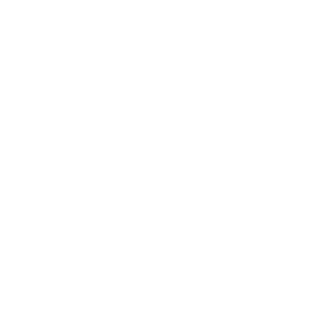

In [5]:
import pyaudio
import wave
from pydub import AudioSegment
import numpy as np
import time
import io
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved Keras model
model = load_model('best_model_CNN.keras')

# Settings for audio recording
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
CHUNK = 1024
SAMPLE_DURATION = 2  # Process audio every 2 seconds
RECORD_SECONDS = SAMPLE_DURATION

classes = ['3Blue1Brown',
 'A Better You Podcast',
 'Just Alex Podcast',
 'Solo Flight Podcast']

# Flag to control the recording loop
recording = True

inputDevice = 0

# Initialize PyAudio
audio = pyaudio.PyAudio()

# Open the audio stream
stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK,
                    input_device_index=inputDevice)

print("Recording... Press 'Enter' to stop.")
frames = []

# Start recording
start_time = time.time()  # To track recording time

def process_audio_to_spectrogram(byte_io):
    # Load the audio data from BytesIO
    y, sr = librosa.load(byte_io, sr=None)

    # Compute the spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    # Create a square figure with no axes or padding
    fig, ax = plt.subplots(figsize=(4, 4), dpi=100)  # Ensure the figure is square
    ax.set_axis_off()  # Turn off axis
    ax.set_aspect('equal')  # This ensures square pixels

    # Display the spectrogram
    librosa.display.specshow(D, sr=sr, cmap='gray', ax=ax)

    # Save the figure to a BytesIO object
    byte_io = io.BytesIO()
    plt.savefig(byte_io, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.close(fig)
    
    # Seek to the start of the BytesIO object
    byte_io.seek(0)

    # Convert the BytesIO to a NumPy array (image)
    img_array = np.frombuffer(byte_io.getvalue(), np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)

    return img  # Return the spectrogram for further processing or prediction

def saveAudio(audio_frames):
    byte_io = io.BytesIO()

    # Open the BytesIO object as if it's a file
    with wave.open(byte_io, 'wb') as wf:
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(audio.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(audio_frames))
    
    byte_io.seek(0)  # Seek to the start of the BytesIO object
    return byte_io

def predict_speaker(spectrogram):
    """Predicts the speaker from the spectrogram."""
    # Reshape for model input and make a prediction
    spectrogram = np.expand_dims(spectrogram, axis=0)  # Adding batch dimension
    prediction = model.predict(spectrogram, verbose=False)
    
    index = np.argmax(prediction[0])
    
    if np.isnan(prediction[0][0]):
        return "Unknown                                                                 "
    
    # Return the predicted speaker index
    return f'{classes[index]}: {prediction[0][index]*100:.2f}%                                                                       '

try:
    while recording:
        try:
            # Read audio data from the stream
            data = stream.read(CHUNK, exception_on_overflow=False)
            frames.append(data)

            # Display elapsed time in seconds
            elapsed_time = int(time.time() - start_time)

            # Every 2 seconds, process the last 2 seconds of audio
            if elapsed_time % RECORD_SECONDS == 0 and elapsed_time > 0:
                # Extract the last 2 seconds of frames
                num_frames = int(RATE * RECORD_SECONDS / CHUNK)
                recent_frames = frames[-num_frames:]
                
                # Convert to spectrogram and make prediction
                bytesFilePath = saveAudio(recent_frames)
                spectrogram = process_audio_to_spectrogram(bytesFilePath)
                speaker_id = predict_speaker(spectrogram)
                
                print(f"Predicted Speaker: {speaker_id}", end="\r")

        except IOError as e:
            print(f"Error reading audio stream: {e}")
            continue

except KeyboardInterrupt:
    print("\nRecording stopped by keyboard interrupt.")

# Stop and close the stream
stream.stop_stream()
stream.close()
audio.terminate()


In [45]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import os
import queue
import sounddevice as sd
import soundfile as sf
from pydub import AudioSegment
from tensorflow.keras.models import load_model
import io
import cv2
import warnings

# Load the saved Keras model
model = load_model('best_model_CNN_1.5_Overlap.keras')

classes = ['3Blue1Brown', 'A Better You Podcast', 'Just Alex Podcast', 'Solo Flight Podcast']

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Set the duration for each chunk (in seconds)
CHUNK_DURATION = 2
SAMPLE_RATE = 44100  # Sample rate for audio processing

def save_spectrogram(y, sr, chunk_number, output_dir):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
    ax.set_axis_off()
    img = librosa.display.specshow(D, sr=sr, cmap='gray', ax=ax)
    ax.set_aspect('equal')    
    
    # Save the figure to a BytesIO object
    byte_io = io.BytesIO()
    plt.savefig(byte_io, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.close(fig)
    
    # Seek to the start of the BytesIO object
    byte_io.seek(0)

    # Convert the BytesIO to a NumPy array (image)
    img_array = np.frombuffer(byte_io.getvalue(), np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)

    return img  # Return the spectrogram for further processing or prediction

def save_audio_chunk(audio_data, chunk_number, output_dir):
    mp3_path = os.path.join(output_dir, f'chunk_{chunk_number}.mp3')
    
    # Save as WAV first, then convert to MP3
    wav_path = os.path.join(output_dir, f'chunk_{chunk_number}.wav')
    sf.write(wav_path, audio_data, SAMPLE_RATE)

    # Convert WAV to MP3 using pydub
    audio_segment = AudioSegment.from_wav(wav_path)
    audio_segment.export(mp3_path, format='mp3')

    # Remove the temporary WAV file
    os.remove(wav_path)

def audio_callback(indata, frames, time, status):
    if status:
        print(status)

    audio_data = indata[:, 0]  # Use the first channel
    q.put(audio_data)

def predict_speaker(spectrogram):
    """Predicts the speaker from the spectrogram."""
    spectrogram = np.expand_dims(spectrogram, axis=0)  # Adding batch dimension
    prediction = model.predict(spectrogram, verbose=False)
    
    index = np.argmax(prediction[0])
    
    if np.isnan(prediction[0][0]):
        return "Unknown"
    
    return f'{classes[index]}: {prediction[0][index]*100:.2f}%'

def process_live_audio(output_dir, chunk_duration=CHUNK_DURATION):
    os.makedirs(output_dir, exist_ok=True)

    global q
    q = queue.Queue()
    chunk_sample_count = SAMPLE_RATE * chunk_duration

    list_audio_devices()

    device_index = int(input("Enter the device index for input: "))
    
    all_audio_buffer = np.array([])

    with sd.InputStream(callback=audio_callback, channels=1, samplerate=SAMPLE_RATE, device=device_index):
        print("Recording live audio... Press Ctrl+C to stop.")
        chunk_number = 1
        while True:
            try:
                audio_chunk = q.get()

                # Append the new audio chunk to the buffer
                all_audio_buffer = np.concatenate((all_audio_buffer, audio_chunk))

                # # Keep only the last 2 seconds of audio
                # if len(all_audio_buffer) > chunk_sample_count:
                #     all_audio_buffer = all_audio_buffer[-chunk_sample_count:]

                # Save the audio if we have enough data
                if len(all_audio_buffer) >= chunk_sample_count:
                    chunk = all_audio_buffer.copy()  # Get the current buffer
                    chunk = chunk[-chunk_sample_count:]

                    # Save the spectrogram
                    audio_img = save_spectrogram(chunk, SAMPLE_RATE, chunk_number, output_dir)
                    
                    # Save the audio chunk as MP3
                    # save_audio_chunk(chunk, chunk_number, output_dir)
                    
                    print(predict_speaker(audio_img), end="\r")
                    chunk_number += 1

            except KeyboardInterrupt:
                print("Recording stopped.")
                break
            except Exception as e:
                raise
                print(f"Error processing audio chunk: {e}")

def list_audio_devices():
    devices = sd.query_devices()
    print("Available audio devices:")
    for i, device in enumerate(devices):
        try:
            with sd.InputStream(callback=audio_callback, channels=1, samplerate=SAMPLE_RATE, device=i):
                audio_chunk = q.get()
            print(f"{i}: {device['name']} - {'Input' if device['max_input_channels'] > 0 else 'Output'}")
        except:
            pass

if __name__ == "__main__":
    SPECTROGRAM_FOLDER = "Dataset/Spectrogram"
    process_live_audio(SPECTROGRAM_FOLDER)


Available audio devices:
0: Microsoft Sound Mapper - Input - Input
1: Voicemeeter Out B3 (VB-Audio Vo - Input
2: Voicemeeter Out A5 (VB-Audio Vo - Input
3: Voicemeeter Out A1 (VB-Audio Vo - Input
4: Microphone (Iriun Webcam) - Input
5: Voicemeeter Out B1 (VB-Audio Vo - Input
6: Voicemeeter Out A2 (VB-Audio Vo - Input
7: Voicemeeter Out A4 (VB-Audio Vo - Input
8: Voicemeeter Out A3 (VB-Audio Vo - Input
9: Microphone (NVIDIA Broadcast) - Input
10: Voicemeeter Out B2 (VB-Audio Vo - Input
11: Microphone (Blue Snowball) - Input
27: Primary Sound Capture Driver - Input
28: Voicemeeter Out B3 (VB-Audio Voicemeeter VAIO) - Input
29: Voicemeeter Out A5 (VB-Audio Voicemeeter VAIO) - Input
30: Voicemeeter Out A1 (VB-Audio Voicemeeter VAIO) - Input
31: Microphone (Iriun Webcam) - Input
32: Voicemeeter Out B1 (VB-Audio Voicemeeter VAIO) - Input
33: Voicemeeter Out A2 (VB-Audio Voicemeeter VAIO) - Input
34: Voicemeeter Out A4 (VB-Audio Voicemeeter VAIO) - Input
35: Voicemeeter Out A3 (VB-Audio Voice

: 

: 

In [9]:
import sounddevice as sd
import numpy as np
import wave
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import os
import queue
import sounddevice as sd
import soundfile as sf
from pydub import AudioSegment
from tensorflow.keras.models import load_model
import io
import cv2
import warnings

# Get available devices
# print("Available recording devices:")
# print(sd.query_devices())

# # Ask the user to select a device
# device_id = int(input("Select a device ID for recording: "))
device_id = 5

# Parameters
fs = 44100  # Sample rate

def RUN(audio_data, chunk_number, output_dir):
    # Example function to process audio data
    print("Running function on the last 2 seconds of audio...")
    # Saving the audio to a WAV file
    with wave.open('last_two_seconds.wav', 'wb') as wf:
        wf.setnchannels(2)
        wf.setsampwidth(2)  # 2 bytes for int16
        wf.setframerate(fs)
        wf.writeframes(audio_data.tobytes())
    print("Processed audio saved as last_two_seconds.wav")
    
    
    # Save the spectrogram
    # audio_img = save_spectrogram(audio_data, SAMPLE_RATE, chunk_number, output_dir)
    # print(predict_speaker(audio_img), end="\r")
    
    # Save the audio chunk as MP3
    # save_audio_chunk(audio_data, chunk_number, output_dir)
    

def process_wav_file(file_path, output_dir, chunk_duration=CHUNK_DURATION, overlap_duration=1.5):
    try:
        y, sr = librosa.load(file_path, sr=None)
    except Exception as e:
        print(f"Couldn't Load: {file_path} - {e}")
        return

    # Skip very short files
    if len(y) < sr * chunk_duration:
        print(f"Skipping short file: {file_path} (length: {len(y)/sr:.2f} seconds)")
        return    

    img = save_spectrogram(y, sr)
    
    print(predict_speaker(img))

def save_spectrogram(y, sr):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
    ax.set_axis_off()
    img = librosa.display.specshow(D, sr=sr, cmap='gray', ax=ax)
    ax.set_aspect('equal')    
    
    # Save the figure to a BytesIO object
    byte_io = io.BytesIO()
    plt.savefig(byte_io, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.close(fig)
    
    # Seek to the start of the BytesIO object
    byte_io.seek(0)

    # Convert the BytesIO to a NumPy array (image)
    img_array = np.frombuffer(byte_io.getvalue(), np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)

    return img  # Return the spectrogram for further processing or prediction

def predict_speaker(spectrogram):
    """Predicts the speaker from the spectrogram."""
    spectrogram = np.expand_dims(spectrogram, axis=0)  # Adding batch dimension
    prediction = model.predict(spectrogram, verbose=False)
    
    index = np.argmax(prediction[0])
    
    if np.isnan(prediction[0][0]):
        return "Unknown"
    
    return f'{classes[index]}: {prediction[0][index]*100:.2f}%'

SPECTROGRAM_FOLDER = "Dataset/Spectrogram"
SAMPLE_RATE = 44100

chunk_number = 1
try:
    while True:
        
        # Record audio for 2 seconds
        print("Recording...")
        recording = sd.rec(int(2 * fs), samplerate=fs, channels=2, dtype='int16', device=device_id)
        sd.wait()  # Wait until recording is finished
        print("Recording finished.")
        
        # Call the RUN function with the recorded audio
        RUN(recording, chunk_number, SPECTROGRAM_FOLDER)
        chunk_number += 1

except KeyboardInterrupt:
    print("Recording stopped.")
except Exception as e:
    print(f"An error occurred: {e}")
    


Recording...
Recording finished.
Running function on the last 2 seconds of audio...
Processed audio saved as last_two_seconds.wav
Recording...
Recording finished.
Running function on the last 2 seconds of audio...
Processed audio saved as last_two_seconds.wav
Recording...
Recording finished.
Running function on the last 2 seconds of audio...
Processed audio saved as last_two_seconds.wav
Recording...
Recording finished.
Running function on the last 2 seconds of audio...
Processed audio saved as last_two_seconds.wav
Recording...
Recording finished.
Running function on the last 2 seconds of audio...
Processed audio saved as last_two_seconds.wav
Recording...
Recording stopped.
